## Trabalho 1 — INF-0618 Deep Learning   


Para este trabalho, utilizaremos a base de dados DermaMNIST, composta de 10.015 imagens (7.007 de treino, 1.003 de validação e 2.005 de teste) subdivididas em 7 classes.

Cada amostra do dado está associada a exatamente um dos seguintes rótulos:
- *actinic keratoses and intraepithelial carcinoma* (0)
- *basal cell carcinoma* (1)
- *benign keratosis-like lesions* (2)
- *dermatofibroma* (3)
- *melanoma* (4)
- *melanocytic nevi* (5)
- *vascular lesions* (6)

<img src="https://medmnist.com/assets/v2/imgs/DermaMNIST.jpg" />

In [77]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## *Download* dos dados

Utilizaremos da bibilioteca curl para baixar a base de dados DermaMNIST. Usaremos o comando da seguinte forma

```
curl -o nome_do_arquivo link_para_download
```


In [1]:
!curl -o dermamnist.npz https://zenodo.org/records/10519652/files/dermamnist.npz?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M  100 18.8M    0     0  7193k      0  0:00:02  0:00:02 --:--:-- 7195k


## Carregando os dados

In [2]:
import numpy as np

In [36]:
# Carrega a base de dados
dermamnist = np.load("dermamnist.npz") # O arquivo chama-se dermamnist.npz (definido no curl)

# Separa em conjuntos de treino, validacao e teste
x_train = dermamnist["train_images"]
y_train = dermamnist["train_labels"]

x_val = dermamnist["val_images"]
y_val = dermamnist["val_labels"]

x_test = dermamnist["test_images"]
y_test = dermamnist["test_labels"]

In [4]:
# para visualizar os dados, utilizaremos a biblioteca matplotlib
from matplotlib import pyplot as plt

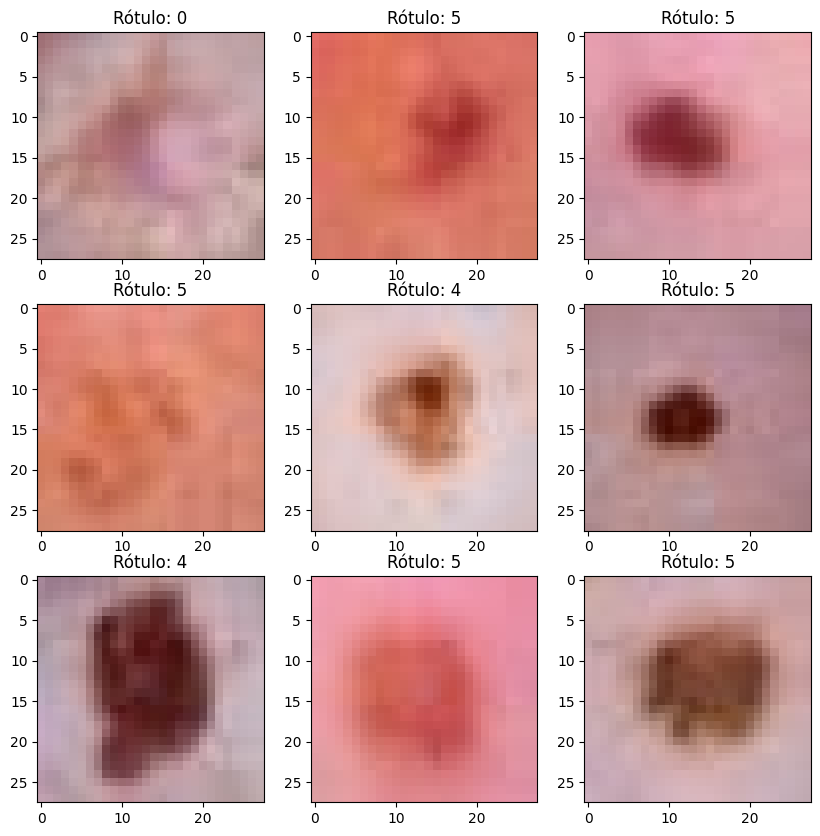

In [5]:
fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
sample = 0
for i in range(3):
    for j in range(3):
        imagem = x_train[sample]
        ax[i][j].imshow(imagem)
        rotulo = y_train[sample][0]
        ax[i][j].title.set_text(f"Rótulo: {rotulo}")
        sample += 1

## Preparação dos dados

In [46]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.7 MB/s eta 0:00:00


In [78]:
import os

In [47]:
import visualkeras

In [20]:
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

In [6]:
x_train.shape

(7007, 28, 28, 3)

In [10]:
y_train.shape

(7007, 1)

In [37]:
# Ajustando o formato da variavel y para one-hot encoding
n_classes = 7

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

In [38]:
# Checando a distribuicao das classes

unique, counts = np.unique(y_train, return_counts=True)
print( "Treino:", dict(zip(unique, counts)) )

# unique, counts = np.unique(y_val, return_counts=True)
# print( "Validacao:",dict(zip(unique, counts)) )

# unique, counts = np.unique(y_test, return_counts=True)
# print( "Teste:",dict(zip(unique, counts)) )

Treino: {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [26]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [31]:
y_train.reshape(-1).shape

(7007,)

In [39]:
# Nossos dados de treinamento estao claramente desbalanceados
# Vamos testar todo o desenvolvimento a seguir utilizando o balanceamento das classes via pesos
# (Caso necessario mudaremos a estrategia posteriormente)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train.reshape(-1)),
                                     y=y_train.reshape(-1))
train_class_weights = dict(enumerate(class_weights))

train_class_weights

{0: 4.390350877192983,
 1: 2.788300835654596,
 2: 1.3016905071521456,
 3: 12.5125,
 4: 1.2849807445442876,
 5: 0.21329639889196675,
 6: 10.11111111111111}

In [40]:
# Normalizando os dados
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0
x_test_norm = x_test / 255.0

In [44]:
x_train_norm[0]

array([[[0.61960784, 0.43529412, 0.45882353],
        [0.63137255, 0.45490196, 0.4745098 ],
        [0.64313725, 0.4745098 , 0.50980392],
        ...,
        [0.74117647, 0.62745098, 0.64313725],
        [0.73333333, 0.61960784, 0.62745098],
        [0.72941176, 0.61568627, 0.62352941]],

       [[0.62745098, 0.44313725, 0.46666667],
        [0.64705882, 0.47058824, 0.49019608],
        [0.66666667, 0.50588235, 0.5372549 ],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.74117647, 0.62745098, 0.63529412],
        [0.7372549 , 0.62352941, 0.63137255]],

       [[0.64313725, 0.46666667, 0.48627451],
        [0.66666667, 0.50196078, 0.51764706],
        [0.69411765, 0.5372549 , 0.56862745],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.7372549 , 0.63529412, 0.64705882],
        [0.73333333, 0.63137255, 0.64313725]],

       ...,

       [[0.6745098 , 0.55686275, 0.58823529],
        [0.69019608, 0.57647059, 0.59607843],
        [0.71372549, 0

## Modelo baseline

In [55]:
x_train_norm.shape[1:]

(28, 28, 3)

In [76]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           data_format=None,
                           dilation_rate=(1, 1),
                           groups=1,
                           activation="relu",
                           use_bias=True,
                           kernel_initializer="glorot_uniform",
                           bias_initializer="zeros",
                           kernel_regularizer=None,
                           bias_regularizer=None,
                           activity_regularizer=None,
                           kernel_constraint=None,
                           bias_constraint=None,
                           input_shape=x_train_norm.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 12)        336       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2028)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 14203     
                                                                 
Total params: 14539 (56.79 KB)
Trainable params: 14539 (56.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


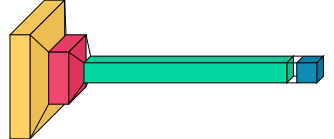

In [60]:
visualkeras.layered_view(baseline_model)

In [80]:
# Compilando o modelo baseline
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

In [81]:
model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_name = "baseline_model.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
baseline_model.fit( x_train_norm, y_train_ohe,
                    epochs=1000,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 1s 9ms/step - loss: 1.3852 - accuracy: 0.5974 - val_loss: 1.1835 - val_accuracy: 0.6690
Epoch 2/1000
25/55 [============>.................] - ETA: 0s - loss: 1.1829 - accuracy: 0.6675

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 7ms/step - loss: 1.1665 - accuracy: 0.6698 - val_loss: 1.1553 - val_accuracy: 0.6690
Epoch 3/1000
55/55 [==============================] - 0s 7ms/step - loss: 1.1493 - accuracy: 0.6698 - val_loss: 1.1450 - val_accuracy: 0.6690
Epoch 4/1000
55/55 [==============================] - 0s 5ms/step - loss: 1.1414 - accuracy: 0.6698 - val_loss: 1.1397 - val_accuracy: 0.6690
Epoch 5/1000
55/55 [==============================] - 0s 7ms/step - loss: 1.1366 - accuracy: 0.6698 - val_loss: 1.1356 - val_accuracy: 0.6690
Epoch 6/1000
55/55 [==============================] - 0s 6ms/step - loss: 1.1330 - accuracy: 0.6698 - val_loss: 1.1323 - val_accuracy: 0.6690
Epoch 7/1000
55/55 [==============================] - 0s 7ms/step - loss: 1.1297 - accuracy: 0.6698 - val_loss: 1.1293 - val_accuracy: 0.6690
Epoch 8/1000
55/55 [==============================] - 0s 7ms/step - loss: 1.1266 - accuracy: 0.6698 - val_loss: 1.1264 - val_accuracy: 0.6690
Epoch 9/1000
55/55 

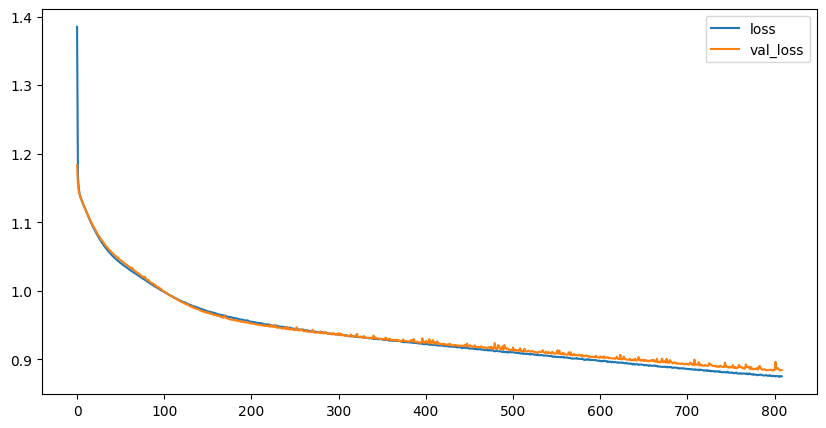

In [82]:
baseline_history = baseline_model.history.history

plt.figure(figsize=(10, 5))

plt.plot(baseline_history["loss"], label="loss")
plt.plot(baseline_history["val_loss"], label="val_loss")

plt.legend()
plt.show()

In [84]:
# Carregando o modelo baseline
baseline_model = tf.keras.models.load_model(model_path_full)

In [85]:
# Avaliando o modelo baseline
baseline_loss, baseline_acc = baseline_model.evaluate(x_val_norm, y_val_ohe)

print(f"Loss: {baseline_loss:.4f}")
print(f"Accuracy: {baseline_acc:.4f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.8837 - accuracy: 0.6800
Loss: 0.8837
Accuracy: 0.6800


In [86]:
import json

validation_results = {
    "model": "baseline",
    "data": "validation",
    "loss": baseline_loss,
    "accuracy": baseline_acc
}

with open(os.path.join(model_path, "validation_results.json"), "w") as f:
    json.dump(validation_results, f)